# **Fit GLM to dmdm data**
---
We first fit normal GLM to the dataset.

## **HPC setting**
Ashwood's original script is written in python scirpts. Here, we rewrite it in Jupyter to make it more user-friendly to run on HPC with `dask`. [This](https://github.com/pierreglaser/hpc-tutorial/tree/main) is very useful resource to get familiar with `dask`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# allocate the computing resources
from dask_jobqueue import SLURMCluster
from distributed import Client
from joblib import Memory, Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits

cluster = SLURMCluster(
    workers=0,      # create the workers "lazily" (upon cluster.scal)
    memory='32g',   # amount of RAM per worker
    processes=1,    # number of execution units per worker (threads and processes)
    cores=1,        # among those execution units, number of processes
    # A lazy trick to avoid matplotlib crash with parallel plotting
    worker_extra_args=["--resources GPU=2"], # the only way to add GPUs
    local_directory='/nfs/nhome/live/skuroda/jobs', # set your path to save log
    log_directory='/nfs/nhome/live/skuroda/jobs' # set your path to save log
)   

memory = Memory('/nfs/nhome/live/skuroda/joblib-cache') # set your path

cluster.scale(10)
client = Client(cluster)
print(client.dashboard_link)

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/

http://192.168.234.51:8787/status


## **Fit GLM to all animals**
---

In [3]:
# ------- load modules -------
import autograd.numpy as np
import autograd.numpy.random as npr
from glm_utils import get_file_dir, load_session_fold_lookup, load_data, fit_glm, \
    plot_input_vectors, append_zeros
from functools import partial
from collections import OrderedDict

In [4]:
# ------- setup variables -------
dname = 'dataAllMice'
C = 4  # number of output types/categories. Hit/FA/Miss/Abort
nested_outcome = OrderedDict() # define nested structure for behavioral outcomes
nested_outcome["Baseline"] = [2, 3]
nested_outcome["Change"] = [0, 1]

N_initializations = 10
num_folds = 5
labels_for_plot = ['CSize', 'COnset', 
                   'PrevMiss?', 'PrevHit?', 'PrevFA?', 'PrevAbort?',
                   'bias']
npr.seed(65)  # set seed in case of randomization

In [5]:
# ------- setup path and load data -------
data_dir =  get_file_dir().parents[2] / "data" / "dmdm" / dname / 'data_for_cluster'
# Create directory for results:
results_dir = get_file_dir().parents[2] / "results" / "dmdm_global_fit_2" / dname
results_dir.mkdir(parents=True, exist_ok=True)

animal_file = data_dir / 'all_animals_concat.npz'
inpt, y, session, rt, stimT = load_data(animal_file)
session_fold_lookup_table = load_session_fold_lookup(
    data_dir / 'all_animals_concat_session_fold_lookup.npz')

In [6]:
def fit_GLM(inpt, y, session, session_fold_lookup_table, labels_for_plot, fold):
    # Subset to relevant covariates for covar set of interest:
    y = y.astype('int')
    figure_directory = results_dir / "GLM" / ("fold_" + str(fold)) 
    figure_directory.mkdir(parents=True, exist_ok=True)

    # Subset to sessions of interest for fold
    sessions_to_keep = session_fold_lookup_table[np.where(
        session_fold_lookup_table[:, 1] != fold), 0]
    idx_this_fold = [
        str(sess) in sessions_to_keep and y[id, 0] != -1
        for id, sess in enumerate(session)
    ]
    this_inpt, this_y, this_session = inpt[idx_this_fold, :], y[
        idx_this_fold, :], session[idx_this_fold]
    assert len(
        np.unique(this_y)
    ) == 4, "choice vector should only include 4 possible values"
    train_size = this_inpt.shape[0]

    M = this_inpt.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly
        loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                         [this_y], 
                                                         M, 
                                                         C)
        # weights_for_plotting = append_zeros(recovered_weights)
        plot_input_vectors(recovered_weights,
                           figure_directory,
                           title="GLM fit; Final LL = " +
                           str(loglikelihood_train),
                           save_title='init' + str(iter),
                           labels_for_plot=labels_for_plot)
        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory / ('variables_of_interest_iter_' + str(iter) + '.npz'), 
            loglikelihood_train, recovered_weights)
        

fit_GLM_eachfold = partial(fit_GLM, inpt, y, session, session_fold_lookup_table, labels_for_plot)        
fit_GLM_eachfold_cached = memory.cache(fit_GLM_eachfold)

In [7]:
%%time
with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=60):
        Parallel(verbose=100)(delayed(fit_GLM_eachfold_cached)(fold) for fold in range(num_folds))

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.0s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   41.3s remaining:   27.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished
CPU times: user 4.51 s, sys: 838 ms, total: 5.35 s
Wall time: 1min 22s


[[[ 402.4824582   290.1413247  -159.26466537 -180.98589638 -173.00730754
   -134.09774482 -646.82070559]
  [ 399.95710472  -95.59430781   52.09718452   60.30178985   56.32519901
     43.82500629  212.86165349]
  [-187.95387638  -97.14138887   53.95042094   61.90432291   58.40606482
     44.92578371  216.01829996]
  [-609.97002332  -97.62602025   53.6461742    60.72833812   56.34085912
     46.09684308  216.79248747]]]


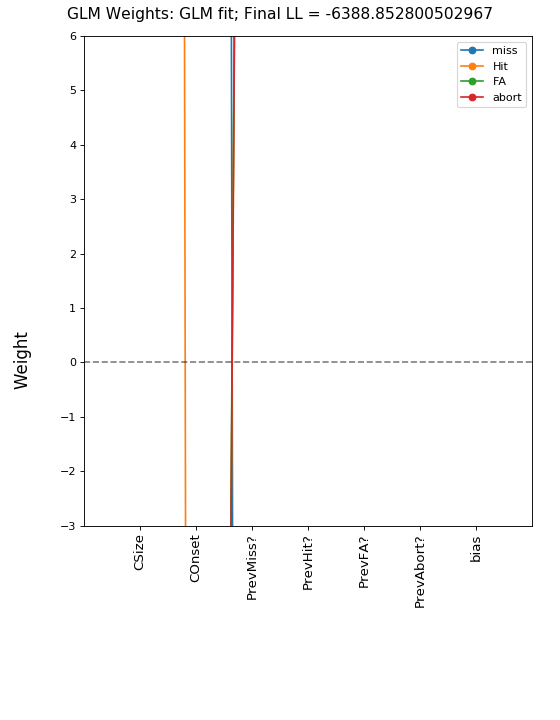

In [8]:
# Plot some results
from IPython.display import Image
example_npz_loc = str(results_dir / "GLM" / "fold_4" / 'variables_of_interest_iter_9.npz')
example_npz = np.load(example_npz_loc)
example_img_loc = str(results_dir / "GLM" / "fold_4" / 'glm_weights_init9.png')
print(example_npz['arr_1'])
Image(filename=example_img_loc) 

## **Fit GLM to each animal separately**
---

In [ ]:
def fit_GLM(inpt, y, session, session_fold_lookup_table, labels_for_plot, fold):

    data_dir = '../../data/ibl/data_for_cluster/data_by_animal/'
    num_folds = 5
    animal_list = load_animal_list(data_dir + 'animal_list.npz')

    results_dir = '../../results/ibl_individual_fit/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

    for animal in animal_list:
        # Fit GLM to data from single animal:
        animal_file = data_dir + animal + '_processed.npz'
        session_fold_lookup_table = load_session_fold_lookup(
            data_dir + animal + '_session_fold_lookup.npz')

        for fold in range(num_folds):
            this_results_dir = results_dir + animal + '/'

            # Load data
            inpt, y, session = load_data(animal_file)
            labels_for_plot = ['stim', 'pc', 'wsls', 'bias']
            y = y.astype('int')

            figure_directory = this_results_dir + "GLM/fold_" + str(fold) + '/'
            if not os.path.exists(figure_directory):
                os.makedirs(figure_directory)

            # Subset to sessions of interest for fold
            sessions_to_keep = session_fold_lookup_table[np.where(
                session_fold_lookup_table[:, 1] != fold), 0]
            idx_this_fold = [
                str(sess) in sessions_to_keep and y[id, 0] != -1
                for id, sess in enumerate(session)
            ]
            this_inpt, this_y, this_session = inpt[idx_this_fold, :], \
                                              y[idx_this_fold, :], \
                                              session[idx_this_fold]
            assert len(
                np.unique(this_y)
            ) == 2, "choice vector should only include 2 possible values"
            train_size = this_inpt.shape[0]

            M = this_inpt.shape[1]
            loglikelihood_train_vector = []

            for iter in range(N_initializations):
                loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                                 [this_y], M,
                                                                 C)
                weights_for_plotting = append_zeros(recovered_weights)
                plot_input_vectors(weights_for_plotting,
                                   figure_directory,
                                   title="GLM fit; Final LL = " +
                                   str(loglikelihood_train),
                                   save_title='init' + str(iter),
                                   labels_for_plot=labels_for_plot)
                loglikelihood_train_vector.append(loglikelihood_train)
                np.savez(
                    figure_directory + 'variables_of_interest_iter_' +
                    str(iter) + '.npz', loglikelihood_train, recovered_weights)


In [ ]:
# Once finished, shut down the cluster and the client
cluster.close()
client.close()